## Stability of UMAP and t-SNE to correlated features

This is a simple demonstration of how modern dimensionality reduction algorithms handle multicollinearity in input data.

This experiment was initially done by [Ilya @iprokin](https://iprokin.github.io/posts/2018-08-26-dimensionality-reduction-with-multicollinearity.html) for vanilla versions of t-SNE/UMAP.

UMAP is generally believed to produce more stable results compared to t-SNE.
However, as it was [recently shown](https://twitter.com/hippopedoid/status/1207999178015727616), the ability of UMAP to preserve the global structure of the data is due to its smart initialization strategy used by default.


Let's see how UMAP and t-SNE handle correlated input features and how initialization in both algorithms contributes to it.

In [1]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import numpy as np
import matplotlib.pylab as plt

Let's generate two features: coordinates $x$ and $y$ of a particle moving in a circle with a little Gaussian noise added. 

In [9]:
phi = np.linspace(0, 6*2*np.pi, 2000)
r = 10
x = r * np.cos(phi) 
y = r * np.sin(phi)

Now let's add some $n_x$ features correlated with $x$. Ideally, the dimensionality reduction algorithm should reveal the structure of data, that is, a cycle. 

Let's see how UMAP (with both default and random initialization) and t-SNE (with both random and PCA initializations) perform in this case: 

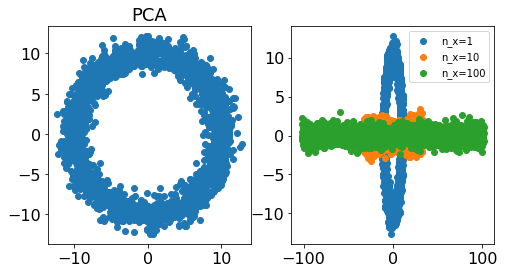

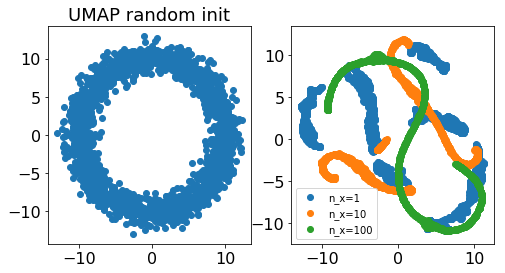

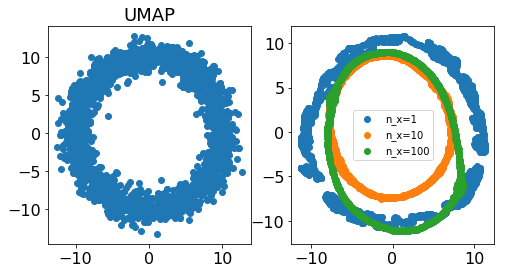

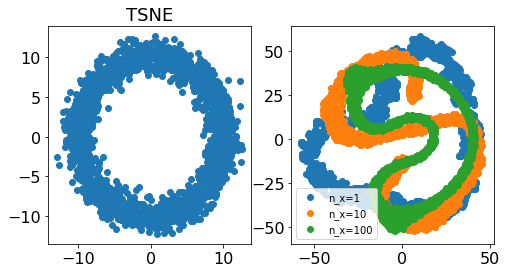

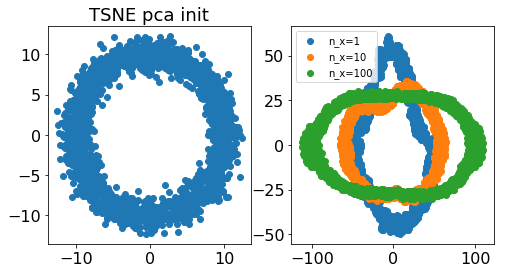

In [11]:
dim_reducers = {
    'PCA': PCA(),
    'UMAP random init': UMAP(init='random'),
    'UMAP': UMAP(),
    'TSNE': TSNE(),
    'TSNE pca init': TSNE(init='pca')
}

for name, reducer in dim_reducers.items():

    # Make design matrix, simulate noisy measurement of the process above. with x first, y last
    X = np.vstack([x + np.random.randn(len(x))] + \
                  [y + np.random.randn(len(y))]).T

    _, axs = plt.subplots(1, 2, figsize=(4*2, 4))

    axs[0].scatter(X[:, 0], X[:, -1])

    for n_x in [1, 10, 100]:
        if n_x > 1:
            X_with_corr = np.hstack(
                [ np.vstack(
                    [ x + np.random.randn(len(x))
                      for _ in range(n_x-1)
                    ]).T
                , X
                ])
        else:
            X_with_corr = X

        X_tr = reducer.fit_transform(X_with_corr)

        axs[1].scatter(X_tr[:, 0], X_tr[:, -1],
                       label="n_x={}".format(n_x))
        axs[1].legend()

    axs[0].set_title(name)

Clearly, the ability of UMAP to map the dataset onto a circle was present only for the spectral (default) initialization strategy, while t-SNE started performing way better with the PCA initialization!